In [15]:
import yfinance as yf
import pandas as pd
import os
import logging
from datetime import datetime
import py_vollib as pv
import py_vollib_vectorized as pvv
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'V', 'DIS']

In [5]:
stock = yf.Ticker(tickers[0])
hist_data = stock.history(period="1mo", interval="5m")
targets = stock.analyst_price_targets

In [6]:
display(hist_data.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-12-30 09:30:00-05:00,274.000000,274.070007,272.790009,272.818512,1047835,0.0,0.0
2025-12-30 09:35:00-05:00,272.815002,273.440002,272.470001,273.160004,331428,0.0,0.0
2025-12-30 09:40:00-05:00,273.170013,273.799988,273.049988,273.320007,273344,0.0,0.0
2025-12-30 09:45:00-05:00,273.309998,273.700012,273.000000,273.600006,215321,0.0,0.0
2025-12-30 09:50:00-05:00,273.600006,273.635010,273.404999,273.630005,145665,0.0,0.0


In [7]:
report_date = "2026-01-21"
file_path = f"/Volumes/SEAGATE/crondata/{report_date}"
expiry_date = "2026-01-30"
options_file = os.path.join(file_path, f"{tickers[0]}_options_{expiry_date}_110002.parquet")

In [8]:
stock_price = hist_data[hist_data.index == '2026-01-21 11:00:00-05:00']
display(stock_price)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-21 11:00:00-05:00,248.169907,248.289993,247.889999,247.999695,288378,0.0,0.0


In [11]:
def clean_options_data(df):
    df = df[df['lastPrice'] > 0]
    df = df[df['volume'] > df['volume'].quantile(0.5)]
    # df['time_to_expiry'] = (pd.to_datetime(df['expiration']) - pd.to_datetime(report_date)).dt.days / 365
    df = df[['contractSymbol', 'lastPrice', 'strike', 'bid', 'ask', 'type', 'impliedVolatility', 'volume']]
    df['type'] = df['type'].map({ 'call': 'c', 'put': 'p' })
    df['TTE'] = (pd.to_datetime("2026-01-30 16:00:00") - pd.to_datetime("2026-01-21 11:00:00")).days / 365
    return df

In [13]:
#combine with option prices and feed into black scholes to get implied vol (check from builtin and compare)
options_data = pd.read_parquet(options_file)
options_data_new = clean_options_data(options_data)
display(options_data_new.head(5))

,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE
12,AAPL260130C00220000,28.20,220.0,28.05,28.55,c,0.433599,91.0,0.024658
16,AAPL260130C00237500,12.85,237.5,12.70,12.85,c,0.375739,37.0,0.024658
17,AAPL260130C00240000,11.05,240.0,10.90,11.00,c,0.372931,319.0,0.024658
18,AAPL260130C00242500,9.42,242.5,9.15,9.30,c,0.370734,149.0,0.024658
19,AAPL260130C00245000,7.80,245.0,7.55,7.70,c,0.365119,521.0,0.024658


In [ ]:
options_data_new['implied_vol_bs'] = pvv.vectorized_implied_volatility(
    price=options_data_new['lastPrice'].values,
    S=stock_price['Open'],
    K=options_data_new['strike'].values,
    t=options_data_new['TTE'].values,
    r=0.035,
    flag=options_data_new['type'].values,
    model='black_scholes',
    return_as='series'
)
display(options_data_new.head(5))

/Users/stark/Desktop/Projects/Options_analysis/venv/lib/python3.13/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 42]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE,implied_vol_bs
12,AAPL260130C00220000,28.20,220.0,28.05,28.55,c,0.433599,91.0,0.024658,0.357840
16,AAPL260130C00237500,12.85,237.5,12.70,12.85,c,0.375739,37.0,0.024658,0.371675
17,AAPL260130C00240000,11.05,240.0,10.90,11.00,c,0.372931,319.0,0.024658,0.375477
18,AAPL260130C00242500,9.42,242.5,9.15,9.30,c,0.370734,149.0,0.024658,0.384164
19,AAPL260130C00245000,7.80,245.0,7.55,7.70,c,0.365119,521.0,0.024658,0.397262


In [29]:
options_data_calls = options_data_new[options_data_new['type'] == 'c'].dropna()
options_data_puts = options_data_new[options_data_new['type'] == 'p'].dropna()
display(options_data_calls)

,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE,implied_vol_bs
12,AAPL260130C00220000,28.20,220.0,28.05,28.55,c,0.433599,91.0,0.024658,0.357840
16,AAPL260130C00237500,12.85,237.5,12.70,12.85,c,0.375739,37.0,0.024658,0.371675
17,AAPL260130C00240000,11.05,240.0,10.90,11.00,c,0.372931,319.0,0.024658,0.375477
18,AAPL260130C00242500,9.42,242.5,9.15,9.30,c,0.370734,149.0,0.024658,0.384164
19,AAPL260130C00245000,7.80,245.0,7.55,7.70,c,0.365119,521.0,0.024658,0.397262
20,AAPL260130C00247500,6.20,247.5,6.30,6.35,c,0.365241,1140.0,0.024658,0.403106
21,AAPL260130C00250000,5.05,250.0,4.95,5.05,c,0.358283,2446.0,0.024658,0.464190
22,AAPL260130C00252500,3.95,252.5,3.85,3.95,c,0.353156,680.0,0.024658,0.958970
23,AAPL260130C00255000,3.03,255.0,2.98,3.05,c,0.350348,3837.0,0.024658,1.259781
24,AAPL260130C00257500,2.28,257.5,2.26,2.30,c,0.347052,511.0,0.024658,0.568776


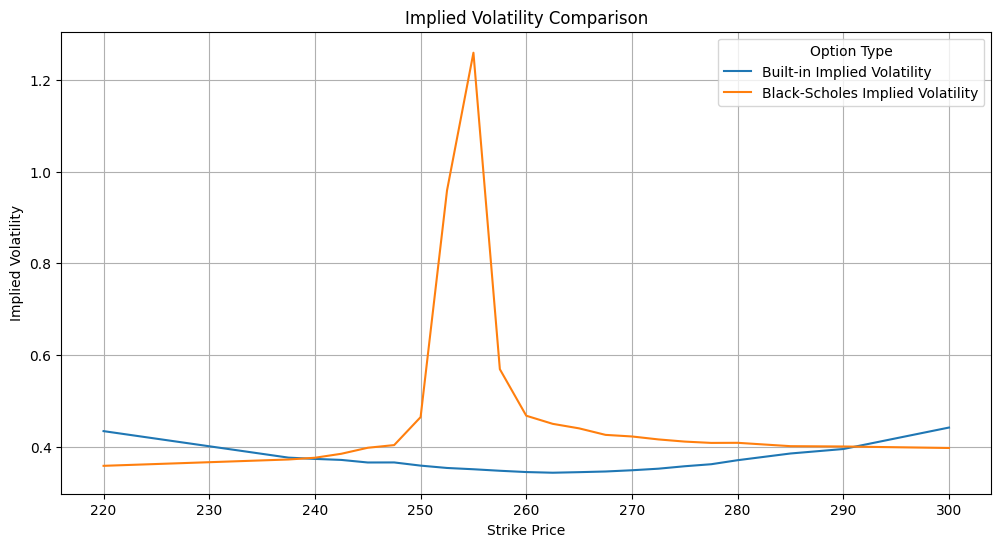

In [30]:
#plot implied vol comparison b/w builtin and black scholes
plt.figure(figsize=(12, 6))
plt.plot(options_data_calls['strike'], options_data_calls['impliedVolatility'], label='Built-in Implied Volatility')
plt.plot(options_data_calls['strike'], options_data_calls['implied_vol_bs'], label='Black-Scholes Implied Volatility')

plt.title('Implied Volatility Comparison')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend(title='Option Type')
plt.grid()
plt.show()